In [3]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.8/373.8 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.6 MB/s eta 0:00:00


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/neuralgcm/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [4]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

## Load a pre-trained NeuralGCM model

By default, this notebook uses the intermediate 1.4° deterministic NeuralGCM model.

[Other available checkpoints](./checkpoints.md) include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations, as well as 2.8° stochastic models that predict precipitation. All models are licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/).

In [5]:
model_name = 'v1_precip/stochastic_precip_2_8_deg.pkl'  #@param ['v1/deterministic_0_7_deg.pkl', 'v1/deterministic_1_4_deg.pkl', 'v1/deterministic_2_8_deg.pkl', 'v1/stochastic_1_4_deg.pkl', 'v1_precip/stochastic_precip_2_8_deg.pkl', 'v1_precip/stochastic_evap_2_8_deg'] {type: "string"}

gcs = gcsfs.GCSFileSystem(token='anon')
with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`data_preparation` for details.

Select out a few days of data from ERA5:

In [6]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(
    era5_path, chunks=None, storage_options=dict(token='anon')
)

demo_start_time = '2024-10-05'
demo_end_time = '2024-10-12'
data_inner_steps = 6  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [7]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [8]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [9]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

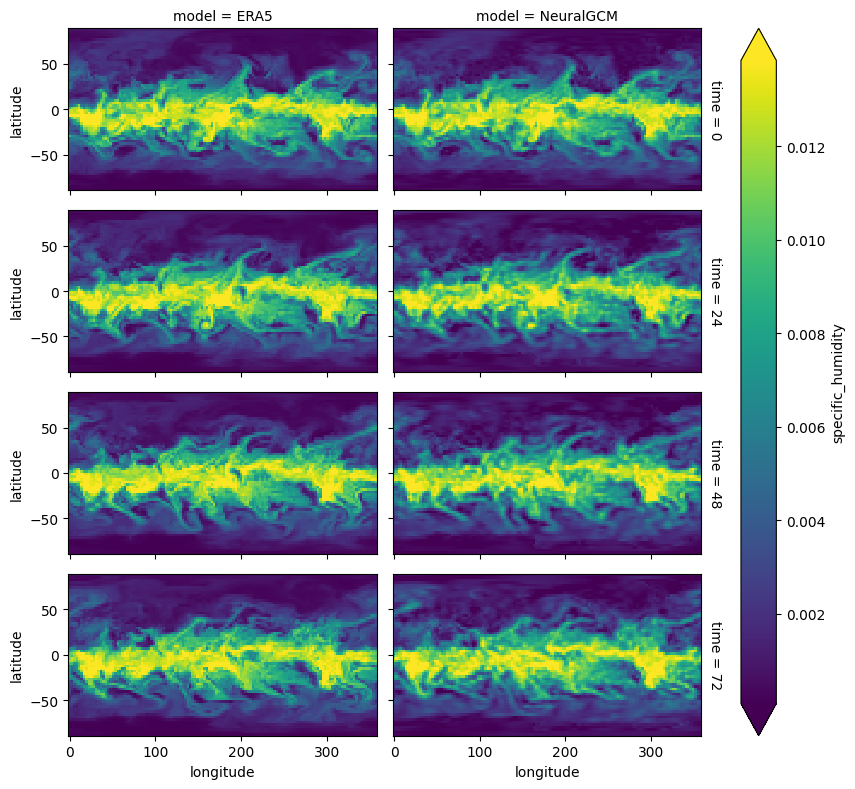

In [10]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);